Выполнил: Кузьмин Андрей, tg: @thisismoto

# ДЗ№2

In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
import datetime
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# !unzip data_ab_homework2-20250117T201629Z-001.zip

In [ ]:
shop_metrics_new = pd.read_csv('data_ab_homework2/shop_df_metrics_dec.csv').drop(columns='Unnamed: 0')
shop_metrics_old = pd.read_csv('data_ab_homework2/shop_df_metrics_sept.csv').drop(columns='Unnamed: 0')
shop_users_info = pd.read_csv('data_ab_homework2/shop_df_users.csv').drop(columns='Unnamed: 0')

In [ ]:
shop_users_info.dtypes

user_id      int64
user_age     int64
user_sex    object
dtype: object

In [ ]:
shop_metrics_new.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0


In [ ]:
shop_metrics_old.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
0,1515915625353226922,B,1,1,76.48,0.0,0.0,0,0
1,1515915625353230067,A,1,1,28.98,0.0,0.0,0,0
2,1515915625353230683,A,1,10,592.21,0.0,0.0,0,0
3,1515915625353230922,A,1,1,274.40,0.0,0.0,0,0
4,1515915625353234047,A,1,14,1857.94,0.0,0.0,0,0


Метрики:
   - is_viewed - айтем товара просмотрен
   - products_viewed_cnt - количество уникальных просмотренных айтемов
   - price_sum - суммарная цена товаров
   - is_cart_added - товар добавлен в корзину
   - is_purchased - товар куплен
   - cart_added_cnt - количество товаров, добавленных в корзину
   - purchased_cnt - количество купленных товаров

<Axes: xlabel='cart_added_cnt', ylabel='Count'>

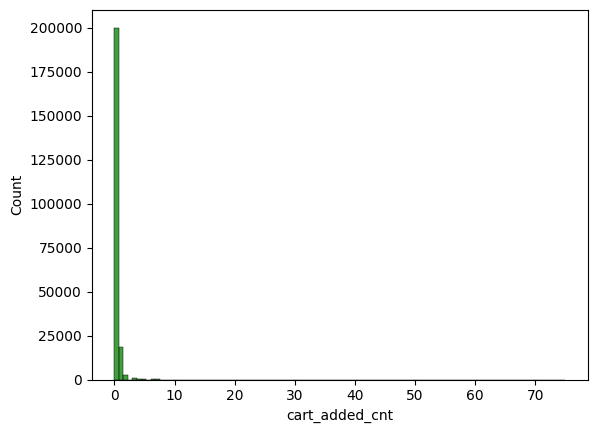

In [ ]:
sns.histplot(data=shop_metrics_new, x='cart_added_cnt', bins=100, color='green')

In [ ]:
shop_metrics_new.cart_added_cnt.value_counts()

cart_added_cnt
0     200076
1      18545
2       2527
3        668
4        304
5        109
6         79
7         48
9         34
8         32
11        21
12        13
10        12
13         7
19         6
15         5
14         5
17         4
21         4
16         3
24         2
23         2
18         2
28         2
25         1
41         1
33         1
22         1
51         1
39         1
20         1
75         1
56         1
38         1
61         1
Name: count, dtype: int64

In [ ]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode
    salt = os.urandom(8)

    return b64encode(salt).decode('ascii')

def groups_splitter(df, user_salt=None):

    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[['user_id', 'group']].drop_duplicates()

In [ ]:
import pandas as pd

def calculate_statistics(df1, metric1, df2, metric2, df3=None, metric3=None):
    # Функция для вычисления статистик для одного датафрейма
    def compute_stats(df, metric):
        # Разделение на группы A и B
        group_A = df[df['group'] == 'A'][metric]
        group_B = df[df['group'] == 'B'][metric]

        # Вычисление средних
        mean_A = group_A.mean()
        mean_B = group_B.mean()

        # Вычисление относительной разницы средних
        relative_difference = (mean_B - mean_A) / mean_A

        # Вычисление дисперсий
        variance_A = group_A.var()
        variance_B = group_B.var()

        return mean_A, mean_B, relative_difference, variance_A, variance_B

    # Создание списка для результатов
    results_list = []

    # Вычисление статистик для первого датафрейма
    mean_A1, mean_B1, rel_diff1, var_A1, var_B1 = compute_stats(df1, metric1)
    results_list.append([metric1, mean_A1, mean_B1, rel_diff1 * 100, var_A1, var_B1])

    # Вычисление статистик для второго датафрейма
    mean_A2, mean_B2, rel_diff2, var_A2, var_B2 = compute_stats(df2, metric2)
    results_list.append([metric2, mean_A2, mean_B2, rel_diff2 * 100, var_A2, var_B2])

    # Проверка и вычисление статистик для третьего датафрейма, если он предоставлен
    if df3 is not None and metric3 is not None:
        mean_A3, mean_B3, rel_diff3, var_A3, var_B3 = compute_stats(df3, metric3)
        results_list.append([metric3, mean_A3, mean_B3, rel_diff3 * 100, var_A3, var_B3])

    # Создание датафрейма с результатами
    results = pd.DataFrame(results_list, columns=[
        'Metric', 'Mean A', 'Mean B', 'Relative Mean Diff, %', 'Variance A', 'Variance B'
    ])

    return round(results.set_index('Metric'), 2)

## 1. Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни на:

In [ ]:
NUM_ITERATIONS = 1000

### Метрика cart_added_cnt (5 баллов)

In [ ]:
def rank_transformation(df_a, df_b, metric):
    df = pd.concat([df_a, df_b], axis = 0)
    df['rank'] = df[metric].rank()

    return df

In [ ]:
ranked = rank_transformation(shop_metrics_new[shop_metrics_new.group == 'A'],
                             shop_metrics_new[shop_metrics_new.group == 'B'], 'cart_added_cnt')

Статистика для ранговой и обычной метрики

In [ ]:
calculate_statistics(ranked, 'rank', shop_metrics_new, 'cart_added_cnt')

,Mean A,Mean B,"Relative Mean Diff, %",Variance A,Variance B
Metric,,,,,
rank,111170.46,111351.64,0.16,1.116109e+09,1.132937e+09
cart_added_cnt,0.14,0.14,2.60,3.800000e-01,4.200000e-01


Средние изменились достаточно сильно (по сравнению с исходными), собственно как и дисперсия, разница между группами 0.16%

T-test для ранговой трансформации

In [ ]:
stats.ttest_ind(ranked[ranked.group == 'A']['rank'],
                ranked[ranked.group == 'B']['rank'])

TtestResult(statistic=np.float64(-1.2743727811526857), pvalue=np.float64(0.20253266477504916), df=np.float64(222519.0))

Различий между группами практичски не было => t-test не нашел разницу

T-test для обычной метрики

In [ ]:
stats.ttest_ind(shop_metrics_new[shop_metrics_new.group == 'A']['cart_added_cnt'],
                shop_metrics_new[shop_metrics_new.group == 'B']['cart_added_cnt'])

TtestResult(statistic=np.float64(-1.3047727178459143), pvalue=np.float64(0.1919716009958315), df=np.float64(222519.0))

Mannwhitneyu для обычной метрики

In [ ]:
stats.mannwhitneyu(shop_metrics_new[shop_metrics_new.group == 'A']['cart_added_cnt'],
                   shop_metrics_new[shop_metrics_new.group == 'B']['cart_added_cnt'])

MannwhitneyuResult(statistic=np.float64(6179368188.5), pvalue=np.float64(0.2025319893087626))

In [ ]:
shop = shop_metrics_new.drop(columns=['group'])

In [ ]:
shop['cart_added_cnt'].std()

np.float64(0.6345408834915941)

### Мощность и корректность

Рангововая трансформация c t-test

In [ ]:
from joblib import Parallel, delayed

# Определяем функцию для одной итерации
def process_iteration(i):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    # Ранговая трансформация без эффекта
    ranked_df = rank_transformation(
        new_df[new_df.group == 'A'],
        new_df[new_df.group == 'B'],
        'cart_added_cnt'
    )
    vec_a = ranked_df[ranked_df['group'] == 'A']['rank']
    vec_b = ranked_df[ranked_df['group'] == 'B']['rank']

    # Применение эффекта к группе B
    vec_b_effect = new_df[new_df['group'] == 'B']['cart_added_cnt'] * 1.05
    new_df_b = new_df[new_df.group == 'B'].drop(columns=['cart_added_cnt'])
    new_df_b['cart_added_cnt'] = vec_b_effect.values

    # Ранговая трансформация с эффектом
    ranked_df_effect = rank_transformation(
        new_df[new_df.group == 'A'],
        new_df_b,
        'cart_added_cnt'
    )
    vec_a_power = ranked_df_effect[ranked_df_effect['group'] == 'A']['rank']
    vec_b_power = ranked_df_effect[ranked_df_effect['group'] == 'B']['rank']

    # Вычисление p-значений
    p_cor = stats.ttest_ind(vec_a, vec_b)[1]
    p_power = stats.ttest_ind(vec_a_power, vec_b_power)[1]

    return p_cor, p_power


# Параллельное выполнение итераций
results = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(NUM_ITERATIONS))
)

# Извлечение результатов
correctness = np.array([res[0] for res in results])
power = np.array([res[1] for res in results])

100%|███████████████████████████████████████| 1000/1000 [01:12<00:00, 13.83it/s]


p_value = 0.5654190548937519 - p_values равномерное распределение
power: 100.0% , correctness: 95.3%


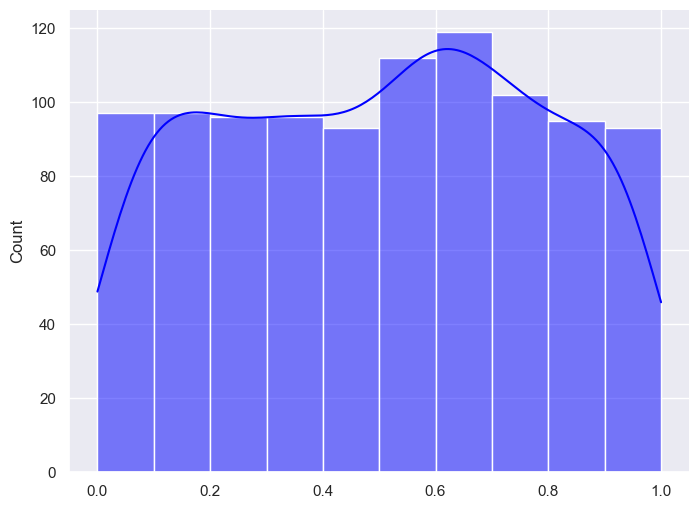

In [ ]:
# Визуализация
sns.set(rc={'figure.figsize': (8, 6)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)
sns.despine()

stat, p_value = scipy.stats.kstest(correctness, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

# Расчет мощности и корректности
power = (np.sum(power < 0.05) / len(power)) * 100
correctness = (1 - (np.sum(correctness < 0.05) / len(correctness))) * 100

print(f'power: {power}% , correctness: {correctness}%')

Обычная метрика с mannwhitneyu

In [ ]:
def process_iteration(i):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    vec_a = new_df[new_df.group == 'A']['cart_added_cnt']
    vec_b = new_df[new_df.group == 'B']['cart_added_cnt']

    # Применение эффекта к группе B
    vec_b_effect = new_df[new_df['group'] == 'B']['cart_added_cnt'] * 1.05

    # Вычисление p-значений
    p_cor = stats.mannwhitneyu(vec_a, vec_b)[1]
    p_power = stats.mannwhitneyu(vec_a, vec_b_effect)[1]

    return p_cor, p_power

# Параллельное выполнение итераций
results = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(NUM_ITERATIONS))
)

# Извлечение результатов
correctness = np.array([res[0] for res in results])
power = np.array([res[1] for res in results])

100%|███████████████████████████████████████| 1000/1000 [01:02<00:00, 16.12it/s]


p_value = 0.06569709689410863 - p_values равномерное распределение
power: 100.0% , correctness: 94.3%


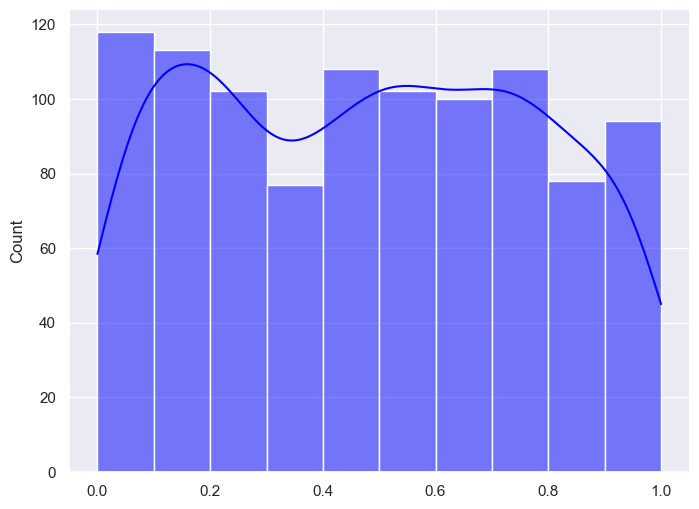

In [ ]:
# Визуализация
sns.set(rc={'figure.figsize': (8, 6)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)
sns.despine()

stat, p_value = scipy.stats.kstest(correctness, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

# Расчет мощности и корректности
power = (np.sum(power < 0.05) / len(power)) * 100
correctness = (1 - (np.sum(correctness < 0.05) / len(correctness))) * 100

print(f'power: {power}% , correctness: {correctness}%')

### Вывод

На обычной метрике cart_added_cnt метод ранговой трансформации (ttest) показал себя примерно одинаково по значению p_value с критерием Манну-Уитни, p_value = 0.2, оба теста не нашли отличий там где их не было, но ранговый критерий сильно увеличивает среднее и дисперсию в этом кейсе, а также уменьшает величину эффекта примерно на порядок.

Также по значению корректности и мощности оба вариата примерно на одном уровне, кроме распределения p_value, у критерия Манну-Уитни распределение находится на границе нормальности и при большем числе итераций оно могло бы стать неравномерным.

K-S, мощность и корректность:

cart_added_cnt метод ранговой трансформации (ttest):
- p_value = 0.5654190548937519 - p_values равномерное распределение
- power: 100.0% , correctness: 95.3%

cart_added_cnt (Манну-Уитни):
- p_value = 0.06569709689410863 - p_values равномерное распределение
- power: 100.0% , correctness: 94.3%

## 2. Реализовать cuped-трансформацию и сравнить мощность t-критерия на:

### Обычная метрика cart_added_cnt (5 баллов)

In [ ]:
def cuped_transform(df, metrics):

    new_columns = [str(m+'_cuped') for m in metrics]
    df[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df.index)

    df_mini = df.fillna(0)
    for m in metrics:
        covariate_column = str(m+'_covariate')
        cuped_column = str(m+'_cuped')
        mean_covariate = df_mini[covariate_column].mean()

        theta = (df_mini[m].cov(df_mini[covariate_column]))/(df_mini.loc[:,covariate_column].var())
        df_mini[cuped_column] = df_mini[m] - (df_mini[covariate_column] - mean_covariate) * theta

    df.update(df_mini)

    return df.drop_duplicates()

In [ ]:
shop_metrics_all = pd.merge(shop_metrics_new,
                            shop_metrics_old[['user_id', 'cart_added_cnt']],
                            on=['user_id'], how='left',
                            suffixes=('', '_covariate'))

In [ ]:
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ['cart_added_cnt'])

Т-test cuped-трансформация

In [ ]:
stats.ttest_ind(shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A']['cart_added_cnt_cuped'],
                shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B']['cart_added_cnt_cuped'])

TtestResult(statistic=np.float64(-1.3855896128448428), pvalue=np.float64(0.1658736404876475), df=np.float64(222519.0))

In [ ]:
calculate_statistics(shop_metrics_all_cuped, 'cart_added_cnt_cuped',
                     shop_metrics_all_cuped, 'cart_added_cnt_covariate',
                     shop_metrics_new, 'cart_added_cnt')

,Mean A,Mean B,"Relative Mean Diff, %",Variance A,Variance B
Metric,,,,,
cart_added_cnt_cuped,0.14,0.14,0.61,0.02,0.02
cart_added_cnt_covariate,0.14,0.14,2.04,0.41,0.46
cart_added_cnt,0.14,0.14,2.60,0.38,0.42


### Мощность и корректность

Cuped-трансформация t-test

In [ ]:
def process_iteration(i):

    warnings.filterwarnings("ignore", category=FutureWarning)

    # Генерация новых групп A и B
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']],
                      on=['user_id'], how='left',
                      suffixes=('', '_covariate'))

    # Применение метода CUPED для уменьшения дисперсии
    cuped_df = cuped_transform(all_df, ['cart_added_cnt'])

    # Разделение данных на группы A и B
    vec_a = cuped_df[cuped_df['group'] == 'A']['cart_added_cnt_cuped']
    vec_b = cuped_df[cuped_df['group'] == 'B']['cart_added_cnt_cuped']

    # Применение эффекта к группе B
    vec_b_effect = vec_b * 1.05

    # Вычисление p-значений с помощью t-теста
    p_cor = stats.ttest_ind(vec_a, vec_b)[1]
    p_power = stats.ttest_ind(vec_a, vec_b_effect)[1]

    return p_cor, p_power

# Параллельное выполнение итераций
results = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(NUM_ITERATIONS))
)

# Извлечение результатов
correctness = np.array([res[0] for res in results])
power = np.array([res[1] for res in results])

100%|███████████████████████████████████████| 1000/1000 [01:19<00:00, 12.50it/s]


p_value = 0.5605175590041962 - p_values равномерное распределение
power: 100.0% , correctness: 95.89999999999999%


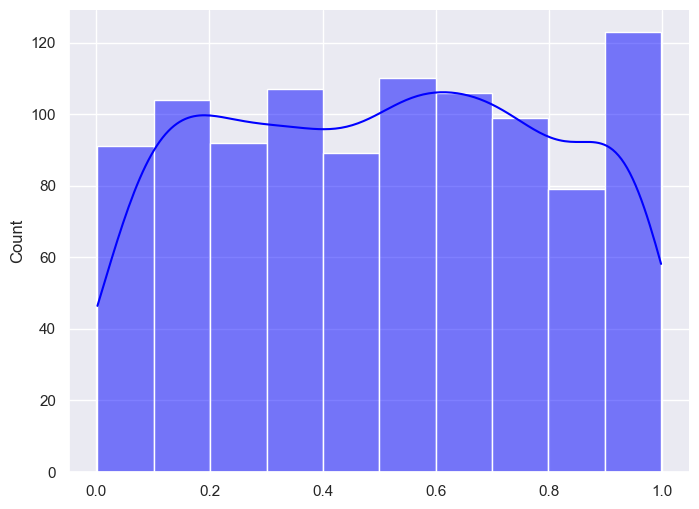

In [ ]:
# Визуализация
sns.set(rc={'figure.figsize': (8, 6)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)
sns.despine()

stat, p_value = scipy.stats.kstest(correctness, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

# Расчет мощности и корректности
power = (np.sum(power < 0.05) / len(power)) * 100
correctness = (1 - (np.sum(correctness < 0.05) / len(correctness))) * 100

print(f'power: {power}% , correctness: {correctness}%')

### логарфимированной метрике cart_added_cnt (5 баллов)

In [ ]:
log_df = shop_metrics_all

log_df['cart_added_cnt_log'] = np.log(log_df['cart_added_cnt'] + 1)
log_df['cart_added_cnt_log_covariate'] = np.log(log_df['cart_added_cnt_covariate'] + 1)

cuped_log_df = cuped_transform(log_df, ['cart_added_cnt_log'])

vec_a_cor = cuped_log_df[cuped_log_df['group'] == 'A']['cart_added_cnt_log_cuped']
vec_b_cor = cuped_log_df[cuped_log_df['group'] == 'B']['cart_added_cnt_log_cuped']

In [ ]:
calculate_statistics(cuped_log_df, 'cart_added_cnt_log_cuped',
                     cuped_log_df, 'cart_added_cnt_log_covariate',
                     cuped_log_df, 'cart_added_cnt_log')

,Mean A,Mean B,"Relative Mean Diff, %",Variance A,Variance B
Metric,,,,,
cart_added_cnt_log_cuped,0.08,0.08,0.47,0.00,0.00
cart_added_cnt_log_covariate,0.08,0.08,1.51,0.07,0.07
cart_added_cnt_log,0.08,0.08,1.98,0.06,0.07


Логарифмированная метрика + cuped ttest

In [ ]:
stats.ttest_ind(vec_a_cor, vec_b_cor)[1]

np.float64(0.04042857406821934)

### Мощность и корректность

Логарифмированная метрика + cuped ttest

In [ ]:
from joblib import Parallel, delayed
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

def process_iteration(i):
    # Генерация новых групп A и B
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on='user_id').drop_duplicates()

    # Объединение с данными о ковариатах (предыдущая метрика)
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']],
                      on='user_id', how='left',
                      suffixes=('', '_covariate'))

    # Логарифмирование текущей метрики и ковариаты (добавляем 1, чтобы избежать log(0))
    all_df['cart_added_cnt_log'] = np.log(all_df['cart_added_cnt'] + 1)
    all_df['cart_added_cnt_log_covariate'] = np.log(all_df['cart_added_cnt_covariate'] + 1)

    # Применение метода CUPED для уменьшения дисперсии (корректность)
    cuped_df = cuped_transform(all_df, ['cart_added_cnt_log'])

    # Разделение данных на группы A и B для корректности
    vec_a_cor = cuped_df[cuped_df['group'] == 'A']['cart_added_cnt_log_cuped']
    vec_b_cor = cuped_df[cuped_df['group'] == 'B']['cart_added_cnt_log_cuped']

    # Вычисление p-значения для корректности (без эффекта)
    p_cor = stats.ttest_ind(vec_a_cor, vec_b_cor)[1]

    # Копируем all_df для применения эффекта
    all_df_power = all_df.copy()

    # Применение эффекта к группе B (только для мощности)
    all_df_power.loc[all_df_power['group'] == 'B', 'cart_added_cnt'] *= 1.05

    # Логарифмирование метрики после применения эффекта
    all_df_power['cart_added_cnt_log'] = np.log(all_df_power['cart_added_cnt'] + 1)

    # Применение метода CUPED для мощности
    cuped_df_power = cuped_transform(all_df_power, ['cart_added_cnt_log'])

    # Разделение данных на группы A и B для мощности
    vec_a_power = cuped_df_power[cuped_df_power['group'] == 'A']['cart_added_cnt_log_cuped']
    vec_b_power = cuped_df_power[cuped_df_power['group'] == 'B']['cart_added_cnt_log_cuped']

    # Вычисление p-значения для мощности (с эффектом)
    p_power = stats.ttest_ind(vec_a_power, vec_b_power)[1]

    return p_cor, p_power

# Параллельное выполнение итераций
results = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(NUM_ITERATIONS))
)

# Извлечение результатов
correctness = np.array([res[0] for res in results])
power = np.array([res[1] for res in results])

100%|███████████████████████████████████████| 1000/1000 [01:45<00:00,  9.51it/s]


p_value = 0.9872394342704364 - p_values равномерное распределение
power: 100.0% , correctness: 95.6%


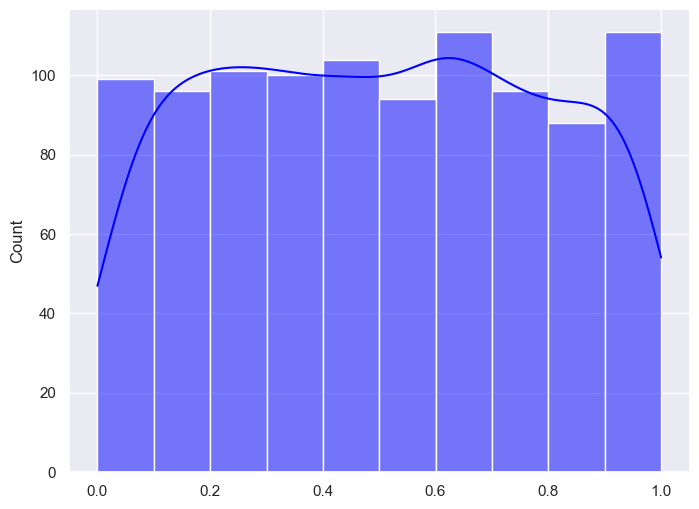

In [ ]:
# Визуализация
sns.set(rc={'figure.figsize': (8, 6)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)
sns.despine()

stat, p_value = scipy.stats.kstest(correctness, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

# Расчет мощности и корректности
power = (np.sum(power < 0.05) / len(power)) * 100
correctness = (1 - (np.sum(correctness < 0.05) / len(correctness))) * 100

print(f'power: {power}% , correctness: {correctness}%')

### метрике cart_added_cnt (а после подвергнуть ранговому преобразованию) (5 баллов)

In [ ]:
cuped_a = shop_metrics_all_cuped[shop_metrics_all_cuped['group'] == 'A']
cuped_b = shop_metrics_all_cuped[shop_metrics_all_cuped['group'] == 'B']

ranked_df = rank_transformation(cuped_a, cuped_b, 'cart_added_cnt_cuped')

ranked_df['cuped_rank'] = ranked_df['rank']

vec_a_rank = ranked_df[ranked_df['group'] == 'A']['rank']
vec_b_rank = ranked_df[ranked_df['group'] == 'B']['rank']

In [ ]:
calculate_statistics(ranked_df, 'cart_added_cnt_cuped',
                     ranked_df, 'cart_added_cnt_covariate',
                     ranked_df, 'cuped_rank')

,Mean A,Mean B,"Relative Mean Diff, %",Variance A,Variance B
Metric,,,,,
cart_added_cnt_cuped,0.14,0.14,0.61,2.000000e-02,2.000000e-02
cart_added_cnt_covariate,0.14,0.14,2.04,4.100000e-01,4.600000e-01
cuped_rank,111157.33,111364.78,0.19,1.138308e+09,1.151769e+09


cuped + ранговая трансформация ttest

In [ ]:
stats.ttest_ind(vec_a_rank, vec_b_rank)

TtestResult(statistic=np.float64(-1.4459909525623789), pvalue=np.float64(0.14818114788143424), df=np.float64(222519.0))

### Мощность и корректность

cuped + ранговая трансформация ttest

In [ ]:
def process_iteration(i):

    warnings.filterwarnings("ignore", category=FutureWarning)

    # Генерация новых групп A и B
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']],
                      on=['user_id'], how='left',
                      suffixes=('', '_covariate'))

    # Применение метода CUPED для уменьшения дисперсии
    cuped_df = cuped_transform(all_df, ['cart_added_cnt'])

    # Разделение данных на группы A и B после CUPED
    cuped_a = cuped_df[cuped_df['group'] == 'A']
    cuped_b = cuped_df[cuped_df['group'] == 'B']

    # Применение эффекта к группе B
    cuped_b_effect = cuped_b.copy()
    cuped_b_effect['cart_added_cnt_cuped'] = cuped_b_effect['cart_added_cnt_cuped'] * 1.05

    # Применение ранговой трансформации без эффекта
    ranked_df = rank_transformation(cuped_a, cuped_b, 'cart_added_cnt_cuped')
    vec_a_rank = ranked_df[ranked_df['group'] == 'A']['rank']
    vec_b_rank = ranked_df[ranked_df['group'] == 'B']['rank']

    # Применение ранговой трансформации с эффектом
    ranked_df_effect = rank_transformation(cuped_a, cuped_b_effect, 'cart_added_cnt_cuped')
    vec_a_rank_effect = ranked_df_effect[ranked_df_effect['group'] == 'A']['rank']
    vec_b_rank_effect = ranked_df_effect[ranked_df_effect['group'] == 'B']['rank']

    # Вычисление p-значений с помощью t-теста
    p_cor = stats.ttest_ind(vec_a_rank, vec_b_rank).pvalue
    p_power = stats.ttest_ind(vec_a_rank_effect, vec_b_rank_effect).pvalue

    return p_cor, p_power

# Параллельное выполнение итераций
results = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(NUM_ITERATIONS))
)

# Извлечение результатов
correctness = np.array([res[0] for res in results])
power = np.array([res[1] for res in results])

100%|███████████████████████████████████████| 1000/1000 [01:29<00:00, 11.14it/s]


p_value = 0.3279054180998051 - p_values равномерное распределение
power: 100.0% , correctness: 94.0%


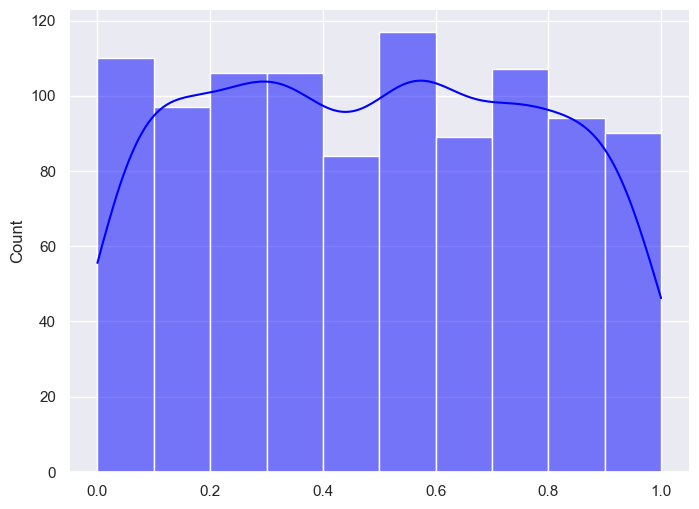

In [ ]:
# Визуализация
sns.set(rc={'figure.figsize': (8, 6)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)
sns.despine()

stat, p_value = scipy.stats.kstest(correctness, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

# Расчет мощности и корректности
power = (np.sum(power < 0.05) / len(power)) * 100
correctness = (1 - (np.sum(correctness < 0.05) / len(correctness))) * 100

print(f'power: {power}% , correctness: {correctness}%')

### Вывод

По резульатам тестов метрика cart_added_cnt с Cuped-преобразованием (ttest=0.16) помогает снизить дисперсию на порядок, как для обычной метрики, так и для логарифмированной (ttest=0.04), значения средних в группах А и В в cuped-метрике, ковариате и обычной равны, что соответствует логике преобразований. Эффект оносительно обычной метрики снижается незначительно на ковариате, а на cuped-метрике на порядок, до 0.61.

T-test на логарифмированной с cuped-преобразованием нашел отличия там где их нет.

Ранговый критерий (ttest=0.14), как в предыдущем задании, сильно увеличивает среднее и дисперсию, а также уменьшает величину эффекта до 0.19.

Самое равномернорное распределение величины p_value на логарифмированной метрике с cuped-преобразованием. K-S статистика равна 0.98. Также ближе всего к заданному уровню ошибки в 0.05 значение корректности на логарифмированной метрике и равняется 95.6%. Мощность для всех комбинаций 100%.

cart_added_cnt с Cuped-преобразованием и cart_added_cnt с Cuped-преобразованием с ранговым преобразованием примерно одинаково по величине мощности и корректности.

K-S, Мощность и корректнось:

cart_added_cnt с Cuped-преобразованием:
- p_value = 0.5605175590041962 - p_values равномерное распределение.  
- power: 100.0% , correctness: 95.89999999999999%.

логарифмированная метрика cart_added_cnt с Cuped-преобразованием:
- p_value = 0.9872394342704364 - p_values равномерное распределение
- power: 100.0% , correctness: 95.6%

метрика cart_added_cnt с Cuped-преобразованием + раноговая трансформация:
- p_value = 0.3279054180998051 - p_values равномерное распределение
- power: 100.0% , correctness: 94.0%

## 3. Реализовать разбивку на бакеты, оценить t-критерием и сравнить с результатом без бакетирования:

### - на логнормальном распределении (сгенерированные данные) (5 баллов)

In [ ]:
def bucket_sample(df, bucket_size, column_name):
    # Функция для бакетирования внутри группы
    def apply_bucket(group):
        # Определяем количество бакетов для текущей группы
        num_buckets = int(np.ceil(len(group) / bucket_size))

        # Создаем индексы бакетов
        bucket_indices = np.repeat(np.arange(num_buckets), bucket_size)[:len(group)]

        # Добавляем индексы бакетов в группу
        group['bucket'] = bucket_indices

        return group

    # Применяем функцию бакетирования к каждой группе, определенной столбцом 'group'
    df = df.groupby('group', group_keys=False).apply(apply_bucket)

    # Считаем среднее значение в каждом бакете по заданному столбцу и возвращаем как DataFrame
    result_df = df.groupby(['group', 'bucket'], as_index=False)[column_name].mean()

    return result_df

In [ ]:
np.random.seed(42)

lognormal_data = pd.DataFrame({'value': np.random.lognormal(mean=0, sigma=1, size=1000000)})

lognormal_data['group'] = np.random.choice(['A', 'B'], size=len(lognormal_data))

bucket_data = bucket_sample(lognormal_data, 10, 'value')

bucket_sort_data = bucket_sample(lognormal_data.sort_values('value'), 10, 'value')

In [ ]:
ex3_stat = calculate_statistics(bucket_data, 'value',
                     bucket_sort_data, 'value',
                     lognormal_data, 'value').reset_index()

ex3_stat['Metric'] = ['bucket_data', 'bucket_sort_data', 'lognormal_data']

ex3_stat.set_index('Metric')

,Mean A,Mean B,"Relative Mean Diff, %",Variance A,Variance B
Metric,,,,,
bucket_data,1.65,1.65,-0.03,0.45,0.46
bucket_sort_data,1.65,1.65,0.08,4.59,4.80
lognormal_data,1.65,1.65,-0.03,4.58,4.61


Бакетирование ttest

In [ ]:
stats.ttest_ind(bucket_data[bucket_data['group'] == 'A']['value'],
                bucket_data[bucket_data['group'] == 'B']['value'])

TtestResult(statistic=np.float64(0.11348266719938499), pvalue=np.float64(0.9096481316887148), df=np.float64(99999.0))

Бакетирование c сортировкой ttest

In [ ]:
stats.ttest_ind(bucket_sort_data[bucket_sort_data['group'] == 'A']['value'],
                bucket_sort_data[bucket_sort_data['group'] == 'B']['value'])

TtestResult(statistic=np.float64(-0.09330608049431387), pvalue=np.float64(0.9256605885484142), df=np.float64(99999.0))

Без бакетирования логнормальное распределение ttest

In [ ]:
stats.ttest_ind(lognormal_data[lognormal_data['group'] == 'A']['value'],
                lognormal_data[lognormal_data['group'] == 'B']['value'])

TtestResult(statistic=np.float64(0.11294303761789681), pvalue=np.float64(0.9100757381888448), df=np.float64(999998.0))

### Мощность и корректность

Бакетирование ttest

In [ ]:
def process_iteration(i):

    warnings.filterwarnings("ignore")

    # Генерация новых групп A и B
    new_group = lognormal_data.copy()
    new_group['group'] = np.random.choice(['A', 'B'], size=len(lognormal_data))

    bucket_data = bucket_sample(new_group, 10, 'value')

    # Разделение данных на группы A и B
    vec_a = bucket_data[bucket_data['group'] == 'A']['value']
    vec_b = bucket_data[bucket_data['group'] == 'B']['value']

    # Применение эффекта к группе B
    vec_b_effect = vec_b * 1.05

    # Вычисление p-значений с помощью t-теста
    p_cor = stats.ttest_ind(vec_a, vec_b)[1]
    p_power = stats.ttest_ind(vec_a, vec_b_effect)[1]

    return p_cor, p_power

# Параллельное выполнение итераций
results = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(NUM_ITERATIONS))
)

# Извлечение результатов
correctness = np.array([res[0] for res in results])
power = np.array([res[1] for res in results])

100%|███████████████████████████████████████| 1000/1000 [00:57<00:00, 17.52it/s]


p_value = 0.263357108973473 - p_values равномерное распределение
power: 100.0% , correctness: 94.19999999999999%


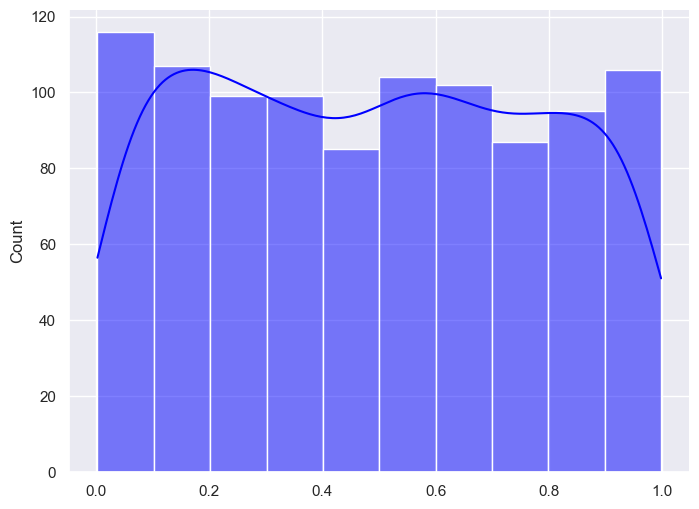

In [ ]:
# Визуализация
sns.set(rc={'figure.figsize': (8, 6)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)
sns.despine()

stat, p_value = scipy.stats.kstest(correctness, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

# Расчет мощности и корректности
power = (np.sum(power < 0.05) / len(power)) * 100
correctness = (1 - (np.sum(correctness < 0.05) / len(correctness))) * 100

print(f'power: {power}% , correctness: {correctness}%')

Бакетирование с сортировкой ttest

In [ ]:
def process_iteration(i):

    warnings.filterwarnings("ignore")

    # Генерация новых групп A и B
    new_group = lognormal_data.copy()
    new_group['group'] = np.random.choice(['A', 'B'], size=len(lognormal_data))

    bucket_sort_data = bucket_sample(new_group, 10, 'value')

    # Разделение данных на группы A и B
    vec_a = bucket_sort_data[bucket_sort_data['group'] == 'A']['value']
    vec_b = bucket_sort_data[bucket_sort_data['group'] == 'B']['value']

    # Применение эффекта к группе B
    vec_b_effect = vec_b * 1.05

    # Вычисление p-значений с помощью t-теста
    p_cor = stats.ttest_ind(vec_a, vec_b)[1]
    p_power = stats.ttest_ind(vec_a, vec_b_effect)[1]

    return p_cor, p_power

# Параллельное выполнение итераций
results = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(NUM_ITERATIONS))
)

# Извлечение результатов
correctness = np.array([res[0] for res in results])
power = np.array([res[1] for res in results])

100%|███████████████████████████████████████| 1000/1000 [00:58<00:00, 17.12it/s]


p_value = 0.541204202914946 - p_values равномерное распределение
power: 100.0% , correctness: 96.3%


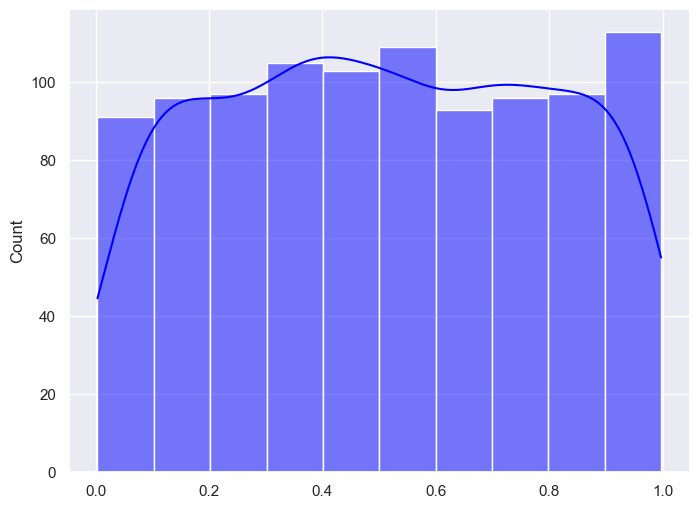

In [ ]:
# Визуализация
sns.set(rc={'figure.figsize': (8, 6)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)
sns.despine()

stat, p_value = scipy.stats.kstest(correctness, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

# Расчет мощности и корректности
power = (np.sum(power < 0.05) / len(power)) * 100
correctness = (1 - (np.sum(correctness < 0.05) / len(correctness))) * 100

print(f'power: {power}% , correctness: {correctness}%')

Без бакетирования логнормальное распределение ttest

In [ ]:
def process_iteration(i):
    # Генерация новых групп A и B
    new_group = lognormal_data.copy()
    new_group['group'] = np.random.choice(['A', 'B'], size=len(lognormal_data))

    # Разделение данных на группы A и B
    vec_a = new_group[new_group['group'] == 'A']['value']
    vec_b = new_group[new_group['group'] == 'B']['value']

    # Применение эффекта к группе B
    vec_b_effect = vec_b * 1.05

    # Вычисление p-значений с помощью t-теста
    p_cor = stats.ttest_ind(vec_a, vec_b)[1]
    p_power = stats.ttest_ind(vec_a, vec_b_effect)[1]

    return p_cor, p_power

# Параллельное выполнение итераций
results = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(NUM_ITERATIONS))
)

# Извлечение результатов
correctness = np.array([res[0] for res in results])
power = np.array([res[1] for res in results])

100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 51.17it/s]


p_value = 0.7635802748711191 - p_values равномерное распределение
power: 100.0% , correctness: 94.6%


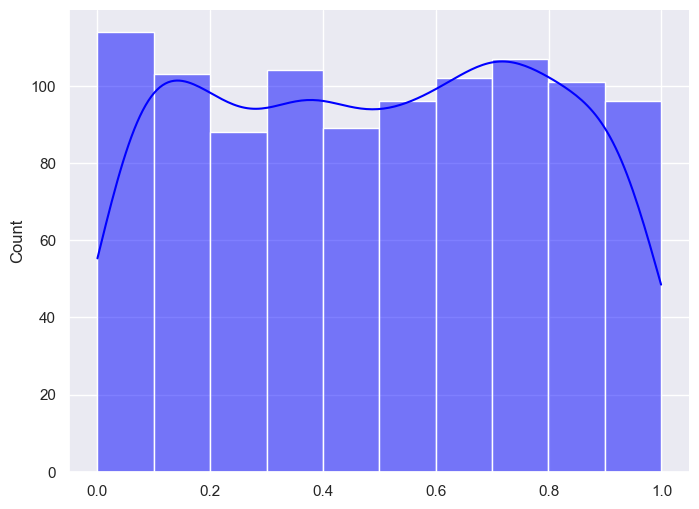

In [ ]:
# Визуализация
sns.set(rc={'figure.figsize': (8, 6)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)
sns.despine()

stat, p_value = scipy.stats.kstest(correctness, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

# Расчет мощности и корректности
power = (np.sum(power < 0.05) / len(power)) * 100
correctness = (1 - (np.sum(correctness < 0.05) / len(correctness))) * 100

print(f'power: {power}% , correctness: {correctness}%')

### - на метрике cart_added_cnt (5 баллов)

In [ ]:
bucket_data = bucket_sample(shop_metrics_new, 3, 'cart_added_cnt')

bucket_sort_data = bucket_sample(shop_metrics_new.sort_values('cart_added_cnt'), 3, 'cart_added_cnt')

print(bucket_data.shape)

(74174, 3)


In [ ]:
ex3_stat = calculate_statistics(bucket_data, 'cart_added_cnt',
                     bucket_sort_data, 'cart_added_cnt',
                     shop_metrics_new, 'cart_added_cnt').reset_index()

ex3_stat['Metric'] = ['bucket_data', 'bucket_sort_data', 'cart_added_cnt']

ex3_stat.set_index('Metric')

,Mean A,Mean B,"Relative Mean Diff, %",Variance A,Variance B
Metric,,,,,
bucket_data,0.14,0.14,2.60,0.13,0.14
bucket_sort_data,0.14,0.14,3.03,0.38,0.46
cart_added_cnt,0.14,0.14,2.60,0.38,0.42


Бакетирование ttest

In [ ]:
stats.ttest_ind(bucket_data[bucket_data['group'] == 'A']['cart_added_cnt'],
                bucket_data[bucket_data['group'] == 'B']['cart_added_cnt'])

TtestResult(statistic=np.float64(-1.3008055004509842), pvalue=np.float64(0.1933290799141004), df=np.float64(74172.0))

Бакетирование с сортировкой ttest

In [ ]:
stats.ttest_ind(bucket_sort_data[bucket_sort_data['group'] == 'A']['cart_added_cnt'],
                bucket_sort_data[bucket_sort_data['group'] == 'B']['cart_added_cnt'])

TtestResult(statistic=np.float64(-0.8618507837444006), pvalue=np.float64(0.3887724212962044), df=np.float64(74172.0))

Без бакетирования ttest

In [ ]:
stats.ttest_ind(shop_metrics_new[shop_metrics_new['group'] == 'A']['cart_added_cnt'],
                shop_metrics_new[shop_metrics_new['group'] == 'B']['cart_added_cnt'])

TtestResult(statistic=np.float64(-1.3047727178459143), pvalue=np.float64(0.1919716009958315), df=np.float64(222519.0))

#### Мощность и корректнось

Бакетирование ttest

In [ ]:
def process_iteration(i):

    warnings.filterwarnings("ignore")

    # Генерация новых групп A и B
    new_group = groups_splitter(shop.copy(),
                                user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    bucket_data = bucket_sample(new_df, 3, 'cart_added_cnt')

    # Разделение данных на группы A и B
    vec_a = bucket_data[bucket_data['group'] == 'A']['cart_added_cnt']
    vec_b = bucket_data[bucket_data['group'] == 'B']['cart_added_cnt']

    # Применение эффекта к группе B
    vec_b_effect = vec_b * 1.05

    # Вычисление p-значений с помощью t-теста
    p_cor = stats.ttest_ind(vec_a, vec_b)[1]
    p_power = stats.ttest_ind(vec_a, vec_b_effect)[1]

    return p_cor, p_power

# Параллельное выполнение итераций
results = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(NUM_ITERATIONS))
)

# Извлечение результатов
correctness = np.array([res[0] for res in results])
power = np.array([res[1] for res in results])

100%|███████████████████████████████████████| 1000/1000 [01:07<00:00, 14.77it/s]


p_value = 0.11238590407540583 - p_values равномерное распределение
power: 70.1% , correctness: 95.7%


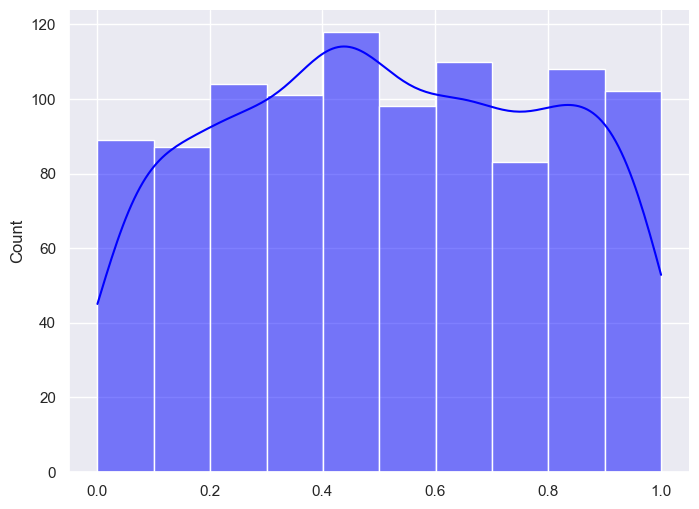

In [ ]:
# Визуализация
sns.set(rc={'figure.figsize': (8, 6)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)
sns.despine()

stat, p_value = scipy.stats.kstest(correctness, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

# Расчет мощности и корректности
power = (np.sum(power < 0.05) / len(power)) * 100
correctness = (1 - (np.sum(correctness < 0.05) / len(correctness))) * 100

print(f'power: {power}% , correctness: {correctness}%')

Бакетирование с сортировкой ttest

In [ ]:
def process_iteration(i):

    warnings.filterwarnings("ignore")

    # Генерация новых групп A и B
    new_group = groups_splitter(shop.copy(),
                                user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    bucket_sort_data = bucket_sample(new_df.sort_values('cart_added_cnt'), 3, 'cart_added_cnt')

    # Разделение данных на группы A и B
    vec_a = bucket_sort_data[bucket_sort_data['group'] == 'A']['cart_added_cnt']
    vec_b = bucket_sort_data[bucket_sort_data['group'] == 'B']['cart_added_cnt']

    # Применение эффекта к группе B
    vec_b_effect = vec_b * 1.05

    # Вычисление p-значений с помощью t-теста
    p_cor = stats.ttest_ind(vec_a, vec_b)[1]
    p_power = stats.ttest_ind(vec_a, vec_b_effect)[1]

    return p_cor, p_power

# Параллельное выполнение итераций
results = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(NUM_ITERATIONS))
)

# Извлечение результатов
correctness = np.array([res[0] for res in results])
power = np.array([res[1] for res in results])

100%|███████████████████████████████████████| 1000/1000 [01:11<00:00, 13.91it/s]


p_value = 1.4057247961602257e-52 - p_values неравномерное распределение
power: 18.0% , correctness: 99.8%


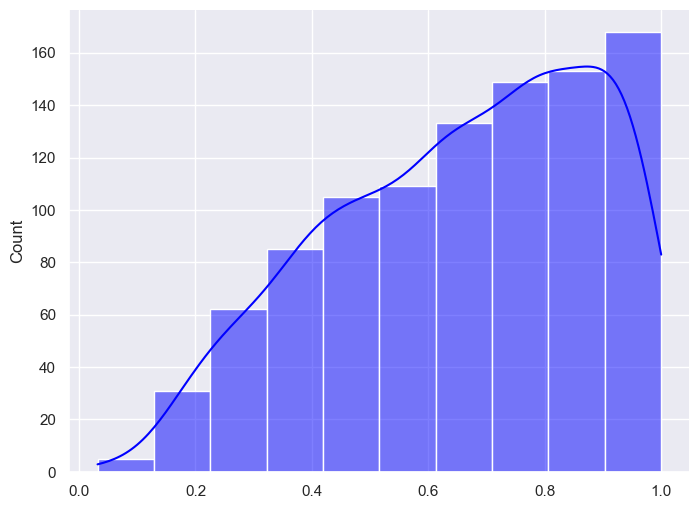

In [ ]:
# Визуализация
sns.set(rc={'figure.figsize': (8, 6)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)
sns.despine()

stat, p_value = scipy.stats.kstest(correctness, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

# Расчет мощности и корректности
power = (np.sum(power < 0.05) / len(power)) * 100
correctness = (1 - (np.sum(correctness < 0.05) / len(correctness))) * 100

print(f'power: {power}% , correctness: {correctness}%')

Без бакетирования ttest

In [ ]:
def process_iteration(i):
    # Генерация новых групп A и B
    new_group = groups_splitter(shop.copy(),
                                user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    # Разделение данных на группы A и B
    vec_a = new_df[new_df['group'] == 'A']['cart_added_cnt']
    vec_b = new_df[new_df['group'] == 'B']['cart_added_cnt']

    # Применение эффекта к группе B
    vec_b_effect = vec_b * 1.05

    # Вычисление p-значений с помощью t-теста
    p_cor = stats.ttest_ind(vec_a, vec_b)[1]
    p_power = stats.ttest_ind(vec_a, vec_b_effect)[1]

    return p_cor, p_power

# Параллельное выполнение итераций
results = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(NUM_ITERATIONS))
)

# Извлечение результатов
correctness = np.array([res[0] for res in results])
power = np.array([res[1] for res in results])

100%|███████████████████████████████████████| 1000/1000 [01:00<00:00, 16.65it/s]


p_value = 0.589549030405886 - p_values равномерное распределение
power: 70.8% , correctness: 95.19999999999999%


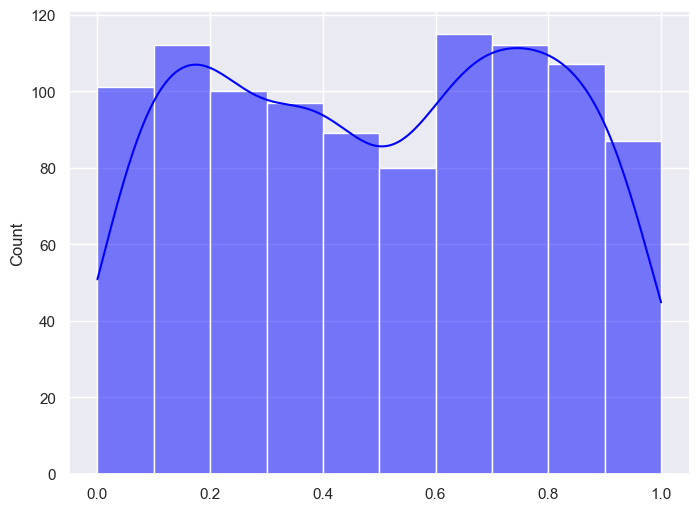

In [ ]:
# Визуализация
sns.set(rc={'figure.figsize': (8, 6)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)
sns.despine()

stat, p_value = scipy.stats.kstest(correctness, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

# Расчет мощности и корректности
power = (np.sum(power < 0.05) / len(power)) * 100
correctness = (1 - (np.sum(correctness < 0.05) / len(correctness))) * 100

print(f'power: {power}% , correctness: {correctness}%')

### Вывод

**Для логнормального распределния:**

T-test для всех комбинаций (логнормальное распределение с бакетированием, логнормальное распределение с бакетированием по сортировке, просто логнормальное распределение) на одном уровне (p_value=0.9), то есть тест не находит отличий там где их нет. Также как и среднее везде равно 1.65 для всех групп, как до бакетирования, так и после.

Бакетирование (без сортировки) не изменило величину эффекта и в 10 раз снизило дисперсию. (с 4.58  на обычной метрике до 0.46).

Самое равномернорное распределение величины p_value было на лонормальной метрике без бакетирования. K-S статистика равна 0.76. Также ближе всего к заданному уровню ошибки в 0.05, значение корректности равняется 94.6. Мощность для всех 3-х случаев 100%.

K-S, Мощность и корректнось:

логнормальное распределение с бакетированием:
- p_value = 0.263357108973473 - p_values равномерное распределение
- power: 100.0% , correctness: 94.19999999999999%

логнормальное распределение с бакетированием по сортировке:
- p_value = 0.541204202914946 - p_values равномерное распределение
- power: 100.0% , correctness: 96.3%

просто логнормальное распределение:
- p_value = 0.7635802748711191 - p_values равномерное распределение
- power: 100.0% , correctness: 94.6%


**На метрике cart_added_cnt:**


T-test для cart_added_cnt с бакетированием, cart_added_cnt без бакетирования на одном уровне (p_value=0.2), cart_added_cnt с бакетированием по сортировке = 0.4, то есть тест не находит отличий там где их нет. Также как и среднее везде равно 0.14 для всех групп, как до бакетирования, так и после.

Бакетирование (без сортировки) не изменило величину эффекта и в 4 раз снизило дисперсию. (с 0.38  на обычной метрике до 0.13). Бакетирование с соритировкой незначительно увеличило эффект и дисперсию.

Мощность и корректность для метрики с бакетированием и без примерно на одном уровке, но немного лучше без бакетирования. K-S статистика равна 0.58. Также ближе всего к заданному уровню ошибки в 0.05, значение корректности равняется 95.2. Мощность 70%.

Распределение p_value для метрики cart_added_cnt с бакетированием по сортировке явно неравномерное, поэтому его в расчет не берем.

K-S, Мощность и корректнось:

метрика cart_added_cnt с бакетированием:
- p_value = 0.11238590407540583 - p_values равномерное распределение
- power: 70.1% , correctness: 95.7%

метрика cart_added_cnt с бакетированием по сортировке:
- p_value = 1.4057247961602257e-52 - p_values неравномерное распределение
- power: 18.0% , correctness: 99.8%

метрика cart_added_cnt:
- p_value = 0.589549030405886 - p_values равномерное распределение
- power: 70.8% , correctness: 95.19999999999999%

## 4. Реализовать постстратификацию на данных shop_metrics_old для метрики cart_added_cnt:

### - на сочетании пола и возраста (возраст разбить на подгруппы: 18-24, 25-45, 46-60, 61-75, 76+) (5 баллов)подсчитать результаты для случая без постстратификации и с постстратификацией

Реализуем стратификацию

In [ ]:
shop_users_info.head()

,user_id,user_age,user_sex
0,1515915625519388267,41,f
1,1515915625519380411,84,m
2,1515915625513238515,41,m
3,1515915625519014356,25,m
4,1515915625510743344,42,m


In [ ]:
shop_w_features = pd.merge(shop_metrics_old, shop_users_info, on=['user_id'], how='left')

In [ ]:
age_bins = [18, 24, 45, 60, 75, float('inf')]
age_labels = ['18-24', '25-45', '46-60', '61-75', '76+']

shop_w_features['age_group'] = pd.cut(shop_w_features['user_age'], bins=age_bins, labels=age_labels, right=True, include_lowest=True)

In [ ]:
shop_w_features.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,user_age,user_sex,age_group
0,1515915625353226922,B,1,1,76.48,0.0,0.0,0,0,55,f,46-60
1,1515915625353230067,A,1,1,28.98,0.0,0.0,0,0,58,m,46-60
2,1515915625353230683,A,1,10,592.21,0.0,0.0,0,0,23,f,18-24
3,1515915625353230922,A,1,1,274.40,0.0,0.0,0,0,33,m,25-45
4,1515915625353234047,A,1,14,1857.94,0.0,0.0,0,0,26,f,25-45


In [ ]:
shop_w_features.groupby(['group', 'age_group', 'user_sex'])['cart_added_cnt'].count()

group  age_group  user_sex
A      18-24      f            8503
                  m           12890
       25-45      f           25540
                  m           38432
       46-60      f           18336
                  m           27321
       61-75      f           17939
                  m           27001
       76+        f           11125
                  m           16249
B      18-24      f            8449
                  m           12816
       25-45      f           25439
                  m           38490
       46-60      f           18111
                  m           27283
       61-75      f           18246
                  m           27249
       76+        f           11082
                  m           16362
Name: cart_added_cnt, dtype: int64

Теперь применим стратификацию и посмотрим, что получится

In [ ]:
# Уникальные пользователи
N = shop_w_features['user_id'].nunique()

# Весовые коэффициенты для каждой комбинации возрастной группы и пола
strats_weights = shop_w_features.groupby(['age_group', 'user_sex']).size() / N

# Расчет среднего и стандартного отклонения с учетом возрастной группы и пола
def calculate_mean_std(df, group, sex, age_group):
    subset = df[(df['group'] == group) &
                             (df['user_sex'] == sex) &
                             (df['age_group'] == age_group)]
    mean = subset['cart_added_cnt'].mean() * strats_weights.get((age_group, sex), 0)
    std = (subset['cart_added_cnt'].std()**2 * strats_weights.get((age_group, sex), 0)) **0.5
    return mean, std

mean_a, std_a = 0, 0
mean_b, std_b = 0, 0

for age_group in age_labels:
    for sex in ['f', 'm']:
        mean_a_temp, std_a_temp = calculate_mean_std(shop_w_features, 'A', sex, age_group)
        mean_b_temp, std_b_temp = calculate_mean_std(shop_w_features, 'B', sex, age_group)

        mean_a += mean_a_temp
        std_a += std_a_temp

        mean_b += mean_b_temp
        std_b += std_b_temp

n_a = len(shop_w_features[shop_w_features.group == 'A'])
n_b = len(shop_w_features[shop_w_features.group == 'B'])

Статистика для постатификации

In [ ]:
print(f'mean_a: {mean_a}, mean_b: {mean_b}, effect: {(mean_b - mean_a)/mean_a*100}, var_a: {std_a ** 2}, var_b: {std_b ** 2}')

mean_a: 0.12020759878965362, mean_b: 0.12155860116106687, effect: 1.1238909894351314, var_a: 3.1026851273428417, var_b: 3.337451082118945


Статистика для обычной метрики

In [ ]:
print('mean_a = ', shop_w_features[shop_w_features.group == 'A']['cart_added_cnt'].mean(),
      'mean_b = ', shop_w_features[shop_w_features.group == 'B']['cart_added_cnt'].mean(),
      'effect =', (shop_w_features[shop_w_features.group == 'B']['cart_added_cnt'].mean() - shop_w_features[shop_w_features.group == 'A']['cart_added_cnt'].mean()) \
    /shop_w_features[shop_w_features.group == 'A']['cart_added_cnt'].mean() * 100,
    'var_a =', shop_w_features[shop_w_features.group == 'A']['cart_added_cnt'].std() ** 2,
    'var_b =', shop_w_features[shop_w_features.group == 'B']['cart_added_cnt'].std() ** 2)

mean_a =  0.1202000629499941 mean_b =  0.12155144034943767 effect = 1.1242734540045785 var_a = 0.3325703408731364 var_b = 0.35851900453600644


Постатификация ttest

In [ ]:
stats.ttest_ind_from_stats(mean_a, std_a, n_a, mean_b, std_b, n_b)

Ttest_indResult(statistic=np.float64(-0.24011203126280783), pvalue=np.float64(0.8102435283828248))

ttest для обычной метрики

In [ ]:
stats.ttest_ind(shop_w_features[shop_w_features['group'] == 'A']['cart_added_cnt'],
                shop_w_features[shop_w_features['group'] == 'B']['cart_added_cnt'])[1]

np.float64(0.4634447828246868)

### - проверить мощность и корректность t-критерия для постстратифицированного случая (5 баллов)

In [ ]:
# Расчет среднего и стандартного отклонения с учетом возрастной группы и пола
def calculate_mean_std_effect(df, group, sex, age_group):
    subset = df[(df['group'] == group) &
                             (df['user_sex'] == sex) &
                             (df['age_group'] == age_group)]
    mean = (subset['cart_added_cnt'] * 1.05).mean() * strats_weights.get((age_group, sex), 0)
    std = ((subset['cart_added_cnt'] * 1.05).std()**2 * strats_weights.get((age_group, sex), 0))
    return mean, std

In [ ]:
# Уникальные пользователи
N = shop_w_features['user_id'].nunique()

# Весовые коэффициенты для каждой комбинации возрастной группы и пола
strats_weights = shop_w_features.groupby(['age_group', 'user_sex']).size() / N

age_bins = [18, 24, 45, 60, 75, float('inf')]

age_labels = ['18-24', '25-45', '46-60', '61-75', '76+']

def process_iteration(i):
    # Генерация новых групп A и B
    new_group = groups_splitter(shop_w_features.drop('group', axis=1).copy(),
                                user_salt=salt_generator())
    new_df = pd.merge(shop_w_features.drop('group', axis=1), new_group, how="left", on=['user_id']).drop_duplicates()
    # Разделение данных на группы A и B

    mean_a, std_a = 0, 0
    mean_b, std_b = 0, 0

    for age_group in age_labels:
        for sex in ['f', 'm']:
            mean_a_temp, std_a_temp = calculate_mean_std(new_df, 'A', sex, age_group)
            mean_b_temp, std_b_temp = calculate_mean_std(new_df, 'B', sex, age_group)

            mean_a += mean_a_temp
            std_a += std_a_temp

            mean_b += mean_b_temp
            std_b += std_b_temp

    n_a = len(new_df[new_df.group == 'A'])
    n_b = len(new_df[new_df.group == 'B'])

    p_cor = stats.ttest_ind_from_stats(mean_a, std_a, n_a, mean_b, std_b, n_b)[1]


    mean_b_eff, std_b_eff = 0, 0

    for age_group in age_labels:
        for sex in ['f', 'm']:

            mean_b_temp, std_b_temp = calculate_mean_std_effect(new_df, 'B', sex, age_group)

            mean_b_eff += mean_b_temp

            std_b_eff += std_b_temp

    n_b_eff = len(new_df[new_df.group == 'B'])

    p_power = stats.ttest_ind_from_stats(mean_a, std_a, n_a, mean_b_eff, std_b_eff, n_b_eff)[1]

    return p_cor, p_power

# Параллельное выполнение итераций
results = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(NUM_ITERATIONS))
)

# Извлечение результатов
correctness = np.array([res[0] for res in results])
power = np.array([res[1] for res in results])

100%|███████████████████████████████████████| 1000/1000 [04:09<00:00,  4.02it/s]


p_value = 4.298951483712962e-213 - p_values неравномерное распределение
power: 18.3% , correctness: 100.0%


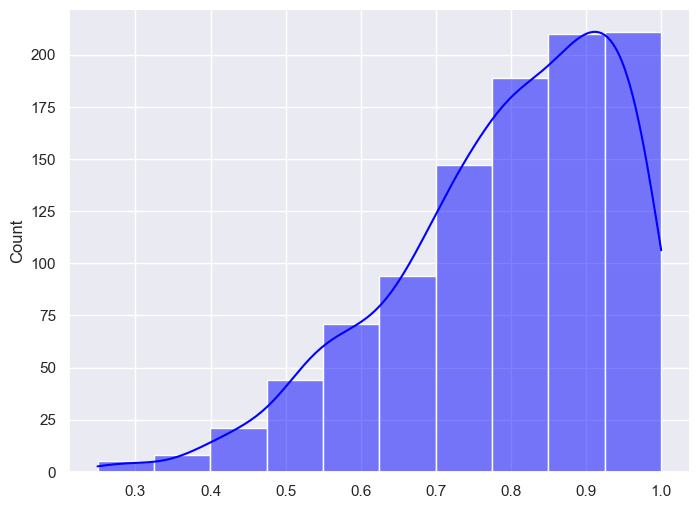

In [ ]:
# Визуализация
sns.set(rc={'figure.figsize': (8, 6)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)
sns.despine()

stat, p_value = scipy.stats.kstest(correctness, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

# Расчет мощности и корректности
power = (np.sum(power < 0.05) / len(power)) * 100
correctness = (1 - (np.sum(correctness < 0.05) / len(correctness))) * 100

print(f'power: {power}% , correctness: {correctness}%')

In [ ]:
def process_iteration(i):
    # Генерация новых групп A и B
    new_group = groups_splitter(shop_w_features.drop('group', axis=1).copy(),
                                user_salt=salt_generator())
    new_df = pd.merge(shop_w_features.drop('group', axis=1), new_group, how="left", on=['user_id']).drop_duplicates()
    # Разделение данных на группы A и B
    vec_a = new_df[new_df['group'] == 'A']['cart_added_cnt']
    vec_b = new_df[new_df['group'] == 'B']['cart_added_cnt']

    # Применение эффекта к группе B
    vec_b_effect = vec_b * 1.05

    # Вычисление p-значений с помощью t-теста
    p_cor = stats.ttest_ind(vec_a, vec_b)[1]
    p_power = stats.ttest_ind(vec_a, vec_b_effect)[1]

    return p_cor, p_power

# Параллельное выполнение итераций
results = Parallel(n_jobs=-1)(
    delayed(process_iteration)(i) for i in tqdm(range(NUM_ITERATIONS))
)

# Извлечение результатов
correctness = np.array([res[0] for res in results])
power = np.array([res[1] for res in results])

100%|███████████████████████████████████████| 1000/1000 [02:04<00:00,  8.06it/s]


p_value = 0.15447520714777407 - p_values равномерное распределение
power: 89.5% , correctness: 96.8%


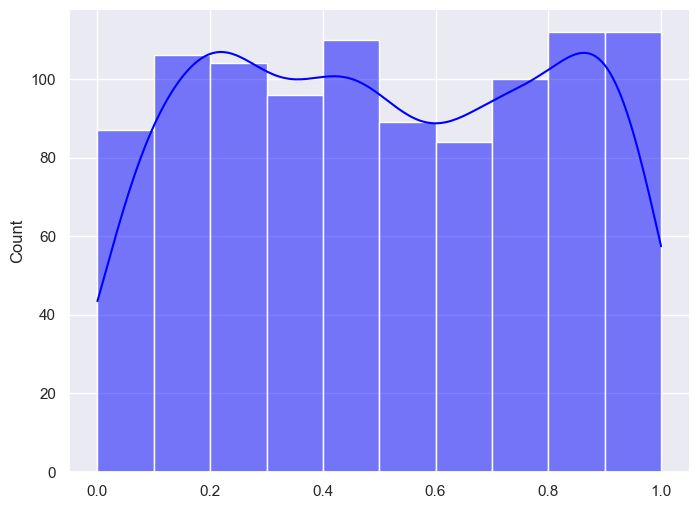

In [ ]:
# Визуализация
sns.set(rc={'figure.figsize': (8, 6)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)
sns.despine()

stat, p_value = scipy.stats.kstest(correctness, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

# Расчет мощности и корректности
power = (np.sum(power < 0.05) / len(power)) * 100
correctness = (1 - (np.sum(correctness < 0.05) / len(correctness))) * 100

print(f'power: {power}% , correctness: {correctness}%')

### Вывод

**Для постратификации:**

T-test для постратификации = 0.8 и без ttest = 0.46, то есть тест не находит отличий там где их нет. Также как и среднее везде равно 0.12 для всех групп, как до постратификации, так и после.

Постратификация не изменила величину эффекта и в 10 раз увеличило дисперсию. (с 0.33  на обычной метрике до 3.10).

Величина K-S распределения показывает, что распределение p_value при применении постатификации неравномерное. Также имеет слабую мощность (18%) и корректность (100%).

Равномернорное распределение величины p_value было на метрике без постратификации. K-S статистика равна 0.15. Также ближе всего к заданному уровню ошибки в 0.05, значение корректности равняется 96.8. Мощность 89.5%.

K-S, Мощность и корректнось:

Постратификация:
- p_value = 4.298951483712962e-213 - p_values неравномерное распределение
- power: 18.3% , correctness: 100.0%

Без постратификации:
- p_value = 0.15447520714777407 - p_values равномерное распределение
- power: 89.5% , correctness: 96.8%